In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import lzma
import json
import urllib.request
import shutil
%matplotlib inline

In [77]:
url = 'https://www.dropbox.com/s/6psloxyc0ekqzh2/data.jsonl.xz?dl=1'

with urllib.request.urlopen(url) as response, open("data.jsonl.xz", 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

This demo is designed to get you up and running with a sample of CAP data available here https://capapi.org/bulk-access/. Feel free to reuse, modify, or distribute it however you'd like. **Most of this code is written to be adaptable to different chunks of CAP data!** You can substitute in another .xz file corresponding to a different jurisdiction or mess around with any number of other parameters.

First, let's get the data into a format we can work with by decompressing the Illinois bulk file and pulling 1-year batches of cases at 10 year intervals from 1900 to 2000. This should give us a good sampling over time.

In [78]:
#a list to hold the cases we're sampling
cases = []

#decompress the file line by line
with lzma.open("data.jsonl.xz") as infile:
    for line in infile:
        #decode the file into a convenient format
        record = json.loads(str(line, 'utf-8'))
        #if the decision date on the case matches one we're interested in, add to our list
        if int(record['decision_date'][:4]) in range(1900, 2010, 10):
            cases.append(record)

print("Number of Cases: {}".format(len(cases)))

Number of Cases: 5020


Let's take a look at the case format by accessing the first entry in our list of matching cases.

In [4]:
cases[0]

{'id': 1152523,
 'name': 'Halliday v. Smith',
 'name_abbreviation': 'Halliday v. Smith',
 'decision_date': '1900-01-06',
 'docket_number': '',
 'first_page': '310',
 'last_page': '313',
 'citations': [{'type': 'official', 'cite': '67 Ark. 310'}],
 'volume': {'volume_number': '67'},
 'reporter': {'full_name': 'Arkansas Reports'},
 'court': {'id': 8808,
  'name': 'Arkansas Supreme Court',
  'name_abbreviation': 'Ark.',
  'jurisdiction_url': None,
  'slug': 'ark'},
 'jurisdiction': {'id': 34,
  'slug': 'ark',
  'name': 'Ark.',
  'name_long': 'Arkansas',
  'whitelisted': True},
 'casebody': {'data': {'judges': [],
   'parties': ['Halliday v. Smith.'],
   'opinions': [{'type': 'majority',
     'author': 'Bunn, C. J.',
     'text': 'Bunn, C. J.\nThis is a bill to enjoin the defendant, Benjamin H. Smith, from obstructing an alleged public road, and from interfering, to prevent their free passage along said road, with the plaintiff’s employees and tenants.\nThe complaint stated, among other th

A lot of info here, but it's quite messy. Let's pull out a few case metadata attributes we're interested in, leaving the actual case text aside for now – the decision date (year only), case name, case citation, court, and opinion count. We'll put them into a Pandas Dataframe for easier manipulation. 

In [5]:
# use a list comprehension to pull out the metadata attributes specified above
case_metadata = [{'year': int(case['decision_date'][:4]),
                'name': case['name'],
                'citation': case['citations'][0]['cite'],
                'court': case['court']['name'],
                'opinion_count': len(case['casebody']['data']['opinions'])} 
                 for case in cases]

# lists of dictionaries like `case_metadata` convert easily into Dataframes
metadata_df = pd.DataFrame(case_metadata)
metadata_df.head()

,citation,court,name,opinion_count,year
0,67 Ark. 310,Arkansas Supreme Court,Halliday v. Smith,1,1900
1,67 Ark. 314,Arkansas Supreme Court,Leach v. State,1,1900
2,67 Ark. 325,Arkansas Supreme Court,Doster v. Manistee National Bank,1,1900
3,67 Ark. 318,Arkansas Supreme Court,Cash v. Kirkham,1,1900
4,67 Ark. 320,Arkansas Supreme Court,Rowland v. McGuire,1,1900


Yay, we've got our first usable data! As minimal as this metadata is, we should still be able to get some useful insights out of it. First, let's check how many cases we have from each year in our sample.

In [6]:
metadata_df['year'].value_counts().sort_index()

1900    164
1910    493
1920    565
1930    506
1940    394
1950    326
1960    258
1970    352
1980    767
1990    594
2000    601
Name: year, dtype: int64

There's clearly a lot of variation in publication volume year to year, with pronounced upticks in 1980 and 2000. Let's break it down by court.

In [7]:
metadata_df['court'].value_counts().sort_index()

Arkansas Court of Appeals     776
Arkansas Supreme Court       4244
Name: court, dtype: int64

All of the cases in our sample are from either the Arkansas Court of Appeals or the Arkansas Supreme Court, with a large majority belonging to the latter. Let's look at the number of opinions per case.

In [8]:
metadata_df['opinion_count'].value_counts().sort_index()

1    4279
2     633
3      89
4      16
5       3
Name: opinion_count, dtype: int64

The majority of our cases have a single opinion. Let's try to identify some trends in opinion volume over time.

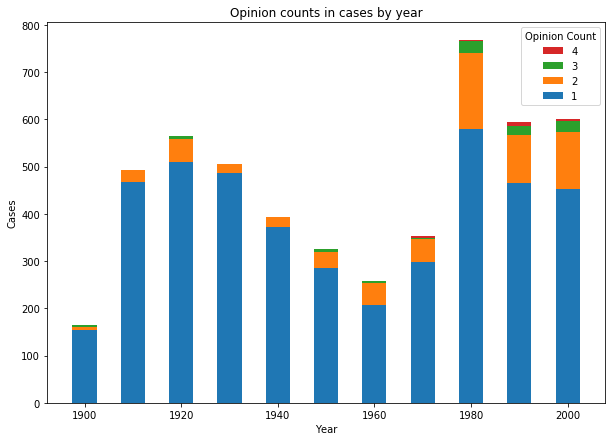

In [9]:
# get frequency of opinion counts for each year
n_opinions = [[year, 
               metadata_df[(metadata_df['year'] == year) & (metadata_df["opinion_count"] == 1)].shape[0],
               metadata_df[(metadata_df['year'] == year) & (metadata_df["opinion_count"] == 2)].shape[0],
               metadata_df[(metadata_df['year'] == year) & (metadata_df["opinion_count"] == 3)].shape[0],
               metadata_df[(metadata_df['year'] == year) & (metadata_df["opinion_count"] >= 4)].shape[0]]
              for year in metadata_df['year'].unique()]

# reformat for graph
n_opinions = list(zip(*n_opinions))
n_opinions = [list(item) for item in n_opinions]
plt.figure(figsize=(10,7))

ind = n_opinions[0]
handles = []
for i, count in enumerate(n_opinions[1:]):
    bot = n_opinions[1:i+1]
    bot = [sum(x) for x in zip(*n_opinions[1:i+1])]
    bot = [0]*len(ind) if not bot else bot
    h = plt.bar(ind, count, 5, bottom=bot, label=i+1)
    handles.append(h)
    
plt.legend(handles=handles[::-1], title="Opinion Count")
plt.xlabel("Year")
plt.ylabel("Cases")
plt.title("Opinion counts in cases by year")
plt.show()

Interesting – it seems that cases from 1980, 1990, and 2000 tend to have more opinions than those from earlier years in the sample.

Now let's get to the rich part of the dataset – the opinions themselves! These are a bit messier to wrangle than the metadata was. There are a couple ways that we might structure our dataframe, but to keep it simple we'll just do one opinion per row. If a case has multiple opinions, each will be a separate row (linked by the case id).

In [10]:
#Loop through cases and build rows with case metadata AND opinion metadata/text.
#We load in all of the keys initially, then modify the ones we want to.

opinion_data = []
for case in cases:
    for opinion in case["casebody"]["data"]["opinions"]:
        temp = {}
        keys = list(case.keys())
        keys.remove('casebody')
        for key in keys:         
            temp[key] = case[key]
        keys = list(opinion.keys())
        for key in keys:         
            temp[key] = opinion[key]
        opinion_data.append(temp)

opinions_df = pd.DataFrame(opinion_data)
opinions_df["citations"] = opinions_df["citations"].apply(lambda x:x[0]['cite'])
opinions_df["court"] = opinions_df["court"].apply(lambda x:x['name'])
opinions_df["decision_date"] = opinions_df["decision_date"].apply(lambda x:int(x[:4]))
opinions_df = opinions_df.drop(["docket_number", "first_page", 
                                "last_page", "name_abbreviation",
                                "reporter", "volume", "jurisdiction"], axis=1)
opinions_df = opinions_df[["id", "name", "decision_date", "court", "citations", "author", "type", "text"]]

opinions_df.head()

,id,name,decision_date,court,citations,author,type,text
0,1152523,Halliday v. Smith,1900,Arkansas Supreme Court,67 Ark. 310,"Bunn, C. J.",majority,"Bunn, C. J.\nThis is a bill to enjoin the defe..."
1,1152531,Leach v. State,1900,Arkansas Supreme Court,67 Ark. 314,"Bunn, C. J.",majority,"Bunn, C. J.\nThis is an indictment against Rob..."
2,1152554,Doster v. Manistee National Bank,1900,Arkansas Supreme Court,67 Ark. 325,"Wood, J.",majority,"Wood, J.\nThis suit is between judgment credit..."
3,1152577,Cash v. Kirkham,1900,Arkansas Supreme Court,67 Ark. 318,"Battle, J.",majority,"Battle, J.\nZ. L. Kirkham presented two accoun..."
4,1152578,Rowland v. McGuire,1900,Arkansas Supreme Court,67 Ark. 320,"Battle, J.",majority,"Battle, J.\nAlice J. Rowland, a married woman,..."


After dropping some extraneous information, we're left with a number of useful attributes for each opinion:

- id (assigned by CAP database): A unique case identifier that we can use to link opinions belonging to the same case
- name: The case's name
- court: The court in which the case was heard and decided
- citations: The official citation to the case
- author: The author of the opinion
- type: The type of the opinion (ex. 'majority,''dissent,''concurrence')
- text: The full text of the opinion

Let's try to a more complicated question using this corpus. Comparing cases from 1900, 1910, 1920, and 1930 against cases from 1970, 1980, 1990, and 2000, what words can we say are distinctive to each time period? Are there words from opinions dating to the beginning of the 20th century that don't occur in opinions dating to the end of the 20th century?

We'll start by implementing a basic n-gram search function and graphing our results. 

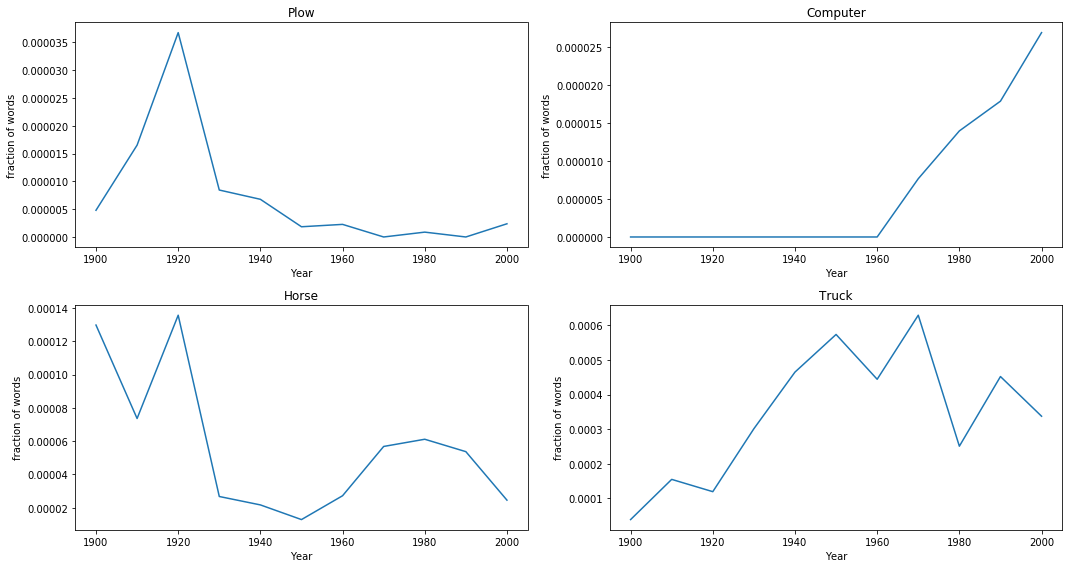

In [23]:
def search_ngram(ngram):
    pairs = []
    for year in opinions_df["decision_date"].unique():
        temp = opinions_df[opinions_df["decision_date"] == year]["text"].tolist()
        temp = " ".join(temp).lower()
        n = len(temp.split(" "))
        ngram_count = temp.count(ngram.lower())
        pairs.append((year, ngram_count/n))
    return pairs

def graph_ngram(pairs, ax, title):
    x,y = [list(x) for x in zip(*pairs)]
    ax.plot(x,y)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("fraction of words")
    return ax

fig, axes = plt.subplots(2, 2, figsize=(15,8))
graph_ngram(search_ngram("plow"), axes[0,0], "Plow")
graph_ngram(search_ngram("computer"), axes[0,1], "Computer")
graph_ngram(search_ngram("horse"), axes[1,0], "Horse")
graph_ngram(search_ngram("truck"), axes[1,1], "Truck")

plt.tight_layout()
plt.show()

Fewer horses and plows, more trucks and computers! Let's get a little bit more sophisticated (still keeping it simple) and find a list of words which occur fewer than 10 times in cases from 1900-1940 but frequently in cases from 1970-2000.

In [28]:
def tokenize_cases(cases):
    cases = " ".join(cases).lower()
    cases = cases.replace("\n", " ").replace(",", "").replace(";", "").replace("'", "").replace("’", "")
    cases = cases.replace("(", "").replace(")", "").replace(".", "").replace("?", "").replace("!", "").split(" ")
    return cases

early_cases = tokenize_cases(opinions_df[opinions_df["decision_date"] <= 1930]["text"].tolist())
late_cases = tokenize_cases(opinions_df[opinions_df["decision_date"] >= 1970]["text"].tolist())

In [29]:
early_cases_dict = {}

for word in early_cases:
    if word in early_cases_dict:
        early_cases_dict[word] += 1
    else:
        early_cases_dict[word] = 1

len(early_cases_dict)

41725

In [66]:
new_words_dict = {}

for word in late_cases:
    if word in early_cases_dict:
        if early_cases_dict[word] < 10:
            if word in new_words_dict:
                new_words_dict[word] += 1
            else:
                new_words_dict[word] = 1
    else:
        if word in new_words_dict:
            new_words_dict[word] += 1
        else:
            new_words_dict[word] = 1

In [67]:
def isInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

sorted_new_words = sorted(new_words_dict.items(), key=lambda x:-x[1])
sorted_new_words = [item for item in sorted_new_words if not isInt(item[0])]
sorted_new_words = sorted_new_words[:100]

print("Most common words from 1970-2000 that occured <10 times from 1900-1930\n")
print ("{0:14}|{1:5}".format("Word", "Occurances"))
print ("-------------------------")
for word in sorted_new_words:
    print ("{0:14}|{1:5}".format(word[0], word[1]))

Most common words from 1970-2000 that occured <10 times from 1900-1930

Word          |Occurances
-------------------------
sw2d          | 8878
repl          | 1700
coverage      |  774
victim        |  678
emphasis      |  606
sw3d          |  598
timely        |  549
marijuana     |  536
percent       |  507
disagree      |  492
factors       |  486
suppress      |  482
cir           |  479
compensable   |  440
problem       |  422
mistrial      |  401
probation     |  400
victims       |  399
surgery       |  393
sentencing    |  389
convictions   |  385
problems      |  374
aggravated    |  368
procedures    |  353
visitation    |  343
cocaine       |  332
subsection    |  319
program       |  317
factual       |  300
wal-mart      |  297
activity      |  294
ineffective   |  292
counsels      |  290
f2d           |  284
pm            |  273
activities    |  268
someone       |  260
parole        |  259
evidentiary   |  257
voter         |  257
prosecutors   |  252
underlying    |

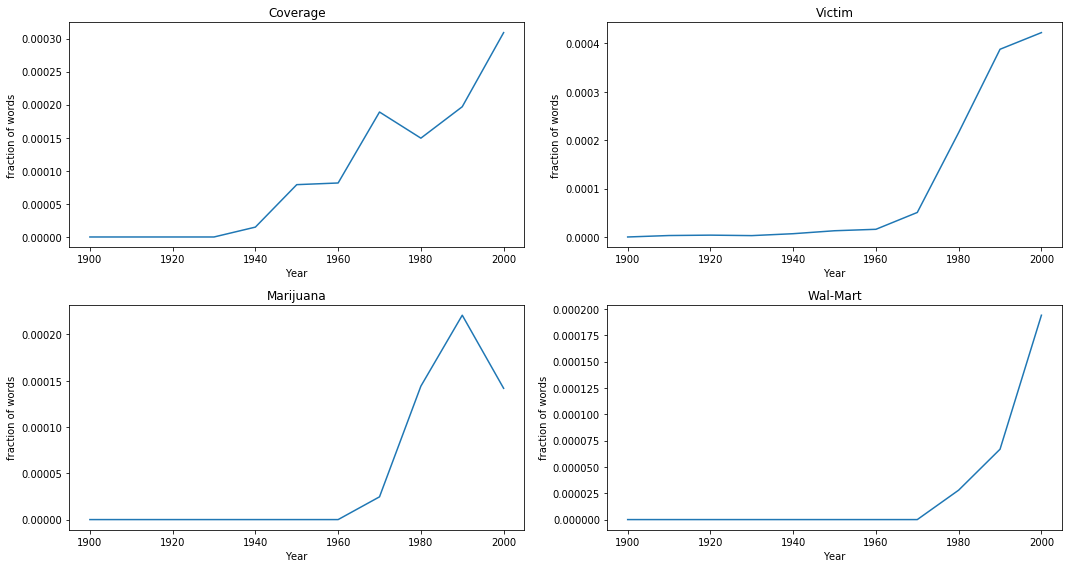

In [68]:
fig, axes = plt.subplots(2, 2, figsize=(15,8))
graph_ngram(search_ngram("coverage"), axes[0,0], "Coverage")
graph_ngram(search_ngram("victim"), axes[0,1], "Victim")
graph_ngram(search_ngram("marijuana"), axes[1,0], "Marijuana")
graph_ngram(search_ngram("wal-mart"), axes[1,1], "Wal-Mart")

plt.tight_layout()
plt.show()